In [1]:
using Plots
using QuadGK
using NLopt
using SpecialFunctions
using NLsolve
include("../../scaling_CGS.jl")

print_all_CGS (generic function with 2 methods)

In [2]:
#---------- Two Steam Setup ----------
base = BaseUnits("CGS")

electron_mass_scaling = 1e0
charge_scaling = 1e0
eps_0_scaling = 1e0
mu_0_scaling = 1e0

scale_base_units(base, eps_0_scaling, mu_0_scaling, charge_scaling, electron_mass_scaling)

mass_density_scale = 1.673532836356e-14
length_scale       = 227.71078654314857
time_scale         = 1.1137516851221212e-9



length= 227.71078654314857
number_density=1e10
B_flux=10
#temperature   = 2.3719594179263036e6  # Corresponds to v_t_e = 0.1*V_0 
temperature   = 2.3719594179263036e6 * 5^2

temperature_e = temperature
temperature_p = temperature



scaling = ScalingCGS(base,
                number_density, length, temperature, temperature_e, temperature_p, B_flux,
                length_scale, mass_density_scale, time_scale)

ds = 0.0025
per_cell = 125

set_macro_particle_weights(scaling, ds, per_cell);
print_all_CGS(scaling)


 Maxwell Lorents Factors used in code:
 k_E =                                             =  1.0000e+00 


 k_B =                                             =  6.8198e+00 
 k_F =                                             =  6.8198e+00 
 k_D =                                             =  1.0000e+00 
 k_M =                                             =  1.4663e-01 
 k_H =                                             =  1.0000e+00 

 Macro particle weights:
                          ds =                     =  2.5000e-03 
                    per_cell =                     =  1.2500e+02 
               weight_scaled =                     =  1.4759e+07 
 weight_scaled_mass_electron =                     =  6.8040e-14 
   weight_scaled_mass_proton =                     =  1.2493e-10 
        weight_scaled_charge =                     =  5.1691e-12 
                 rho_n_ratio =                     =  1.1807e+17 

 Fundamental physical constants:


        Gravitational Constant [ cm^3 g^-1 s^-2 ]  =  6.6743e-08  4.8171e+31  1.3855e-39
          Boltzmann's Constant [ erg K^-1 ]        =  1.3806e-16  8.2599e+15  1.6715e-32
             Planck's Constant [ erg s ]           =  6.6261e-27  9.1995e+06  7.2026e-34
              Atomic Mass Unit [ g ]               =  1.6605e-24  1.9760e-07  8.4036e-18
                   Proton Mass [ g ]               =  1.6726e-24  1.9760e-07  8.4647e-18
                 Electron Mass [ g ]               =  9.1094e-28  1.9760e-07  4.6100e-21
             Elementary Charge [ StatC ]           =  4.8032e-10  1.3714e+09  3.5023e-19
           Vacuum Permittivity [ ]                 =  1.1127e-21  2.3923e-23  4.6510e+01
           Vacuum Permeability [ s^2 cm^-2 ]       =  1.0000e+00  1.0000e+00  1.0000e+00
                Speed of Light [ cm/s ]            =  2.9979e+10  2.0445e+11  1.4663e-01
                 Electron Volt [ erg ]             =  1.6022e-12  8.2599e+15  1.9397e-28
         Mean molecul

In [3]:
c = scaling.c_code


m_i = scaling.m_p_code
m_e = scaling.m_e_code


t = scaling.temperature_code


n_i = scaling.number_density_code
n_e = scaling.number_density_code

k_B = scaling.k_B_code

V_0 = scaling.c_code * 0.2

v_t_e = scaling.v_thermal_e_code
v_t_p = scaling.v_thermal_p_code


omega_e = scaling.electron_plasma_freq_code
omega_p = scaling.proton_plasma_freq_code

debye_e = scaling.debye_len_code
debye_i = scaling.v_thermal_p_code / scaling.proton_plasma_freq_code


skin_depth = scaling.skin_depth_p_code

1.0

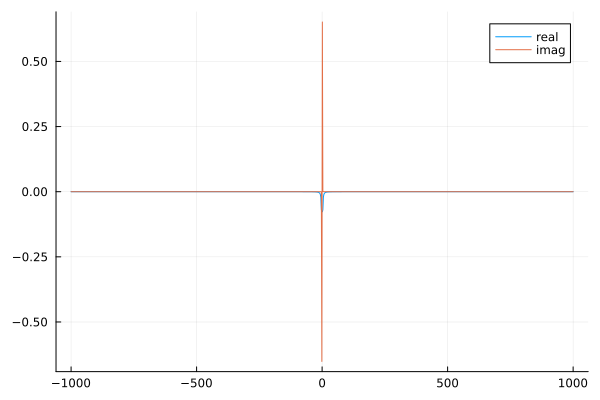

In [4]:
function W_val(z)
    return 1. + 1im * z * sqrt(pi) * faddeeva(z)
end

#------- to verify this is implemented correctly --------------------
z_vals  = collect(range(-1000,stop=1000, length=1000))  #.+ 1.0im
W_res = W_val.(z_vals);

plot(real.(z_vals), real.(W_res),label="real")
plot!(real.(z_vals), imag.(W_res),label="imag")
#---------------------------------------------------------------


In [6]:
"
    full_dispertion_relation

compute the full dispersion relation for the warm electron-proton case
"
function full_dispertion_relation(omega, k, V0, v_t_e, v_t_i, debye_e, debye_i)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    z_0     = (omega / k )     / (sqrt(2.) * v_t_i)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_plus)
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_minus)
    ion_part        = 1.0 / ( debye_i * k )^2.0           * W_val(z_0)
    #TODO Make sure there is no factor sqrt(2) hiding somewhere 
    return 1. + electorn_part_1 + electorn_part_2 + ion_part
end
"
    warm_elec_dispertion

compute the warm dispersion relation for the warm electron only case
"
function warm_elec_dispertion(omega, k, V0, v_t_e, debye_e)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_plus)
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_minus)
    return 1. + electorn_part_1 + electorn_part_2
end
"
    cold_dispertion_relation

compute the cold dispersion relation for the cold electron-proton case
"
function cold_dispertion_relation(omega, k, V0, omega_e, omega_i)
    electorn_part_1 = 1.0/2.0 * omega_e^2  * ( 1 / (omega + V0 *k)^2 )
    electorn_part_2 = 1.0/2.0 * omega_e^2  * ( 1 / (omega - V0 *k)^2 )
    ion_part        =           omega_i^2        / omega^2
    return 1 - electorn_part_1 - electorn_part_2 - ion_part
end
"
    cold_dispertion_relation

compute the cold dispersion relation for the cold electron only case
"
function cold_elec_dispertion_relation(omega, k, V0, omega_e)
    electorn_part_1 = 1.0/2.0 * omega_e^2  * ( 1 / (omega + V0 *k)^2 )
    electorn_part_2 = 1.0/2.0 * omega_e^2  * ( 1 / (omega - V0 *k)^2 )
    return 1 - electorn_part_1 - electorn_part_2
end

#-------- function wrappers to be used by the newton-rhapson implementation ----------------
function function_wrapper(omega, args...)
    return full_dispertion_relation(omega, args...)
end

function function_wrapper_warm(omega, args...)
    return warm_elec_dispertion(omega, args...)
end

function function_wrapper_cold(omega, args...)
    return cold_dispertion_relation(omega, args...)
end
#----------------------------------------

function_wrapper_cold (generic function with 1 method)

In [7]:
function numerical_derivative_imag(f, z; h=1e-5)
    h_val = h * 1.0im
    return (f(z + h_val) - f(z - h_val)) / (2.0*h_val)
end

function numerical_derivative_real(f, z; h=1e-5)
    h_val = h
    return (f(z + h_val) - f(z - h_val)) / (2.0*h_val)
end

function newton_raphson_complex(f, initial_guess; tol=1e-8, max_iterations=100, h=1e-5, step_size=1e-1)
    z = initial_guess
    for i in 1:max_iterations
        fz = f(z)
        dfz_real = numerical_derivative_real(f, z, h=h) 
        #dfz_imag = numerical_derivative_imag(f, z, h=h)  #TODO highly unstable if I take a step both in real and imaginary plane

        if abs(dfz_real) < tol
            return z, f(z), "derivative too small to continue"
            #println("Numerical derivative too small; division by zero or near-zero encountered")
        end

        #----------------- change step size to avoid too large steps ------------
        step_real = (fz / dfz_real) 
        step = step_real #+ step_imag
        step_sign = sign(step)

        if abs(step) > abs(z)
            step = step_sign * max(abs(z), 1.0) * step_size
        else
            step *= step_size
        end
        #--------–--------–--------–--------–--------–--------–--------–

        #--------– Update value of z --------–--------–--------–
        z_new = z - step
        #--------–--------–--------–--------–--------–

        # Check for convergence
        if abs(z_new - z) < tol
            return z_new, f(z_new), "Converged after $i iterations"
        end

        z = z_new
    end

    return z, f(z),  "Stopped after reaching the maximum number of iterations"
end


newton_raphson_complex (generic function with 1 method)

In [12]:
#----------- Calculate the analytical solution for the cold electron only case -------–-------–-------–-------–-------–-------–-------–
k_vals           = collect(range(0,stop=2, length=1000)) *  scaling.skin_depth_scaling

cold_omega_1 = -sqrt.( (-sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_2 = -sqrt.( (+sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_3 =  sqrt.( (-sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_4 =  sqrt.( (+sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im);

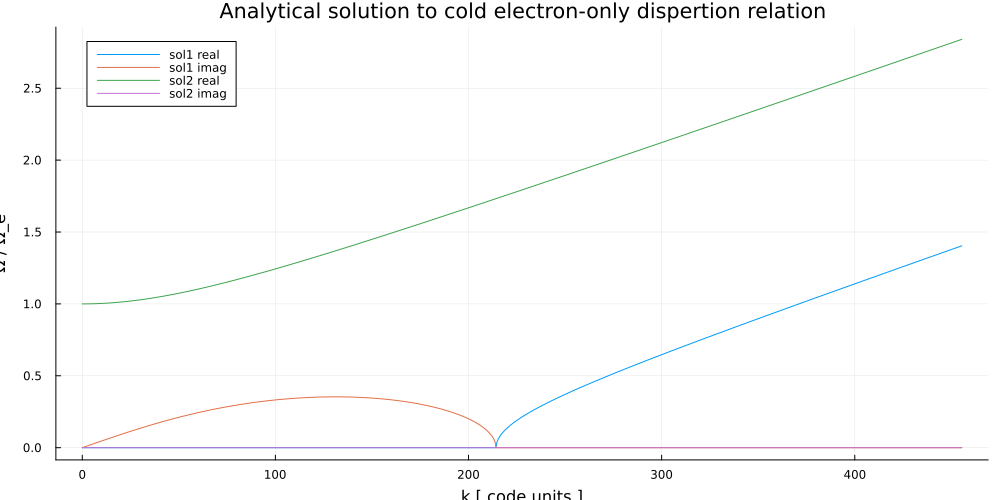

In [14]:
#-------– Plot the analytical solution for the positive omega cases -------–-------–-------–-------– 
plot(k_vals, real.(cold_omega_3 / omega_e), label="sol1 real", title="Analytical solution to cold electron-only dispertion relation",
    size=(1000,500), xlabel="k [ code units ]", ylabel = "Ω / Ω_e")
plot!(k_vals, imag.(cold_omega_3/ omega_e), label="sol1 imag")
plot!(k_vals, real.(cold_omega_4/ omega_e), label="sol2 real")
plot!(k_vals, imag.(cold_omega_4/ omega_e), label="sol2 imag")

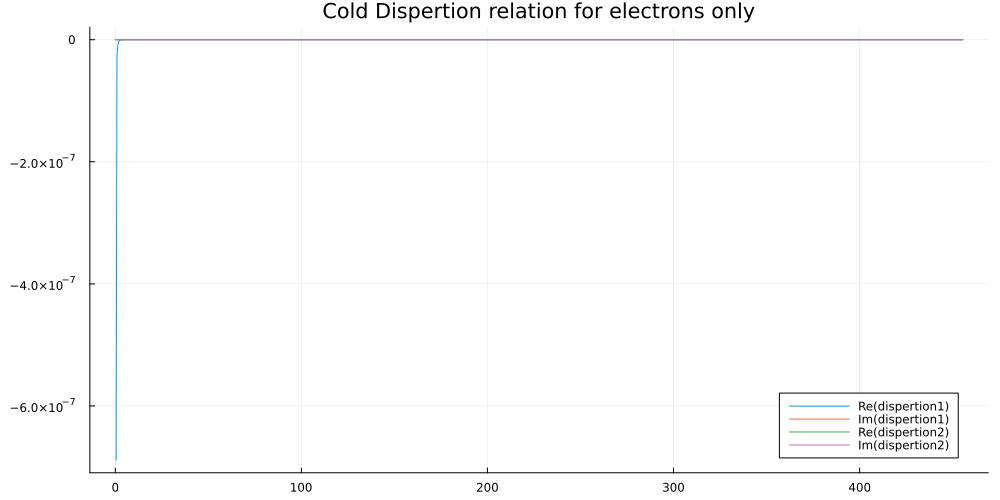

In [15]:
#-------–-------– calculate and plot the value of the dispertion relation given the analytical solution -------–-------–
#               Should be numerically zero
cold_elec_dis_res1 = cold_elec_dispertion_relation.(cold_omega_3, k_vals, V_0, omega_e)
cold_elec_dis_res2 = cold_elec_dispertion_relation.(cold_omega_4, k_vals, V_0, omega_e)

plot( k_vals, real.(cold_elec_dis_res1), label = "Re(dispertion1)", title="Cold Dispertion relation for electrons only", size=(1000,500))
plot!(k_vals, imag.(cold_elec_dis_res1), label = "Im(dispertion1)")
plot!(k_vals, real.(cold_elec_dis_res2), label = "Re(dispertion2)")
plot!(k_vals, imag.(cold_elec_dis_res2), label = "Im(dispertion2)")

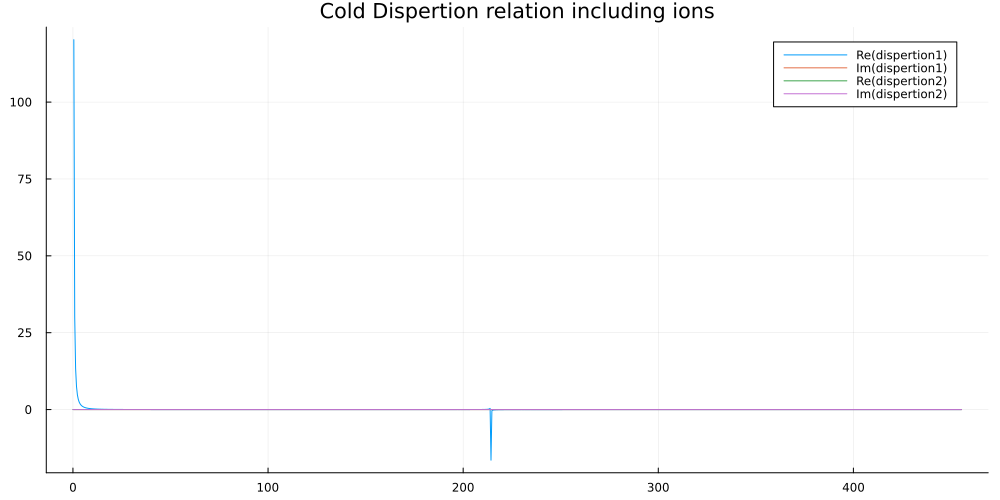

In [16]:
#-------– Test the analytical solution when we also take into account ions in the cold case -------–-------–
cold_dis_res1 = cold_dispertion_relation.(cold_omega_3, k_vals, V_0, omega_e,omega_p)
cold_dis_res2 = cold_dispertion_relation.(cold_omega_4, k_vals, V_0, omega_e,omega_p)

plot( k_vals, real.(cold_dis_res1), label = "Re(dispertion1)", title="Cold Dispertion relation including ions", size=(1000,500))
plot!(k_vals, imag.(cold_dis_res1), label = "Im(dispertion1)")
plot!(k_vals, real.(cold_dis_res2), label = "Re(dispertion2)")
plot!(k_vals, imag.(cold_dis_res2), label = "Im(dispertion2)")

131.2927057546082


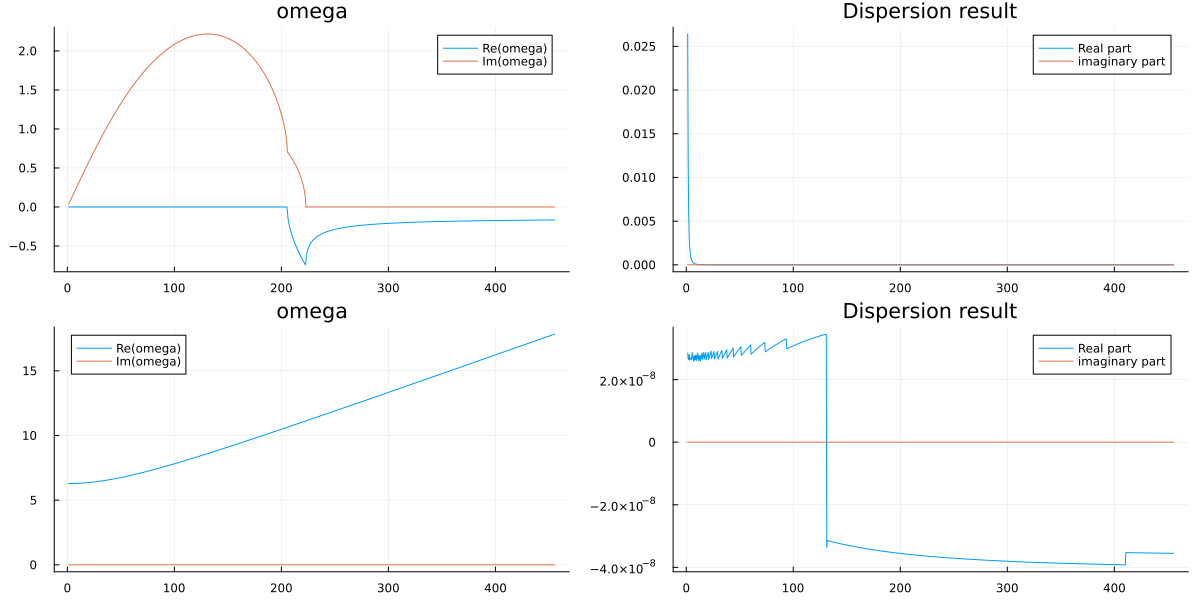

In [19]:


sol_cold1 = zeros(ComplexF64, size(k_vals))
sol_cold2 = zeros(ComplexF64, size(k_vals));


#-------- Start by finding a solution near k_max -------–-------–-------–-------–-------–-------–
k_max_index = argmax(imag.(cold_omega_3))
k_max = k_vals[k_max_index]
println(k_max)
args_cold = (k_max, V_0, omega_e, omega_p)


initial_guess1 =  cold_omega_3[k_max_index]  + (1.0 + 1.0im) * 1e-6
res1, msg = newton_raphson_complex(x -> function_wrapper_cold(x, args_cold...), initial_guess1,max_iterations=200,h=1e-4)
sol_cold1[k_max_index] = res1


initial_guess2 =  cold_omega_4[k_max_index]  + (1.0 + 1.0im) * 1e-6
res2, msg = newton_raphson_complex(x -> function_wrapper_cold(x, args_cold...), initial_guess2,max_iterations=200,h=1e-4)
sol_cold2[k_max_index] = res2
#-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–


#-------– For k> k_max let the initial guess by the previous solution, and then find a new solution used newton-rhapson -------–-------–
for i in k_max_index+1:size(k_vals)[1]
    args_cold = (k_vals[i], V_0, omega_e, omega_p)

    initial_guess1 = sol_cold1[i-1]
    res1, msg = newton_raphson_complex(x -> function_wrapper_cold(x, args_cold...), initial_guess1,max_iterations=200,h=1e-5)
    sol_cold1[i] = res1

    initial_guess2 = sol_cold2[i-1]
    res2, msg = newton_raphson_complex(x -> function_wrapper_cold(x, args_cold...), initial_guess2,max_iterations=200,h=1e-5)
    sol_cold2[i] = res2
end 
#-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–
#-------– Find similar solutions for k<k_max
for i in k_max_index-1:-1:1
    args_cold = (k_vals[i], V_0, omega_e, omega_p)
    initial_guess1 = sol_cold1[i+1]
    res1, msg = newton_raphson_complex(x -> function_wrapper_cold(x, args_cold...), initial_guess1,max_iterations=200,h=1e-5)
    sol_cold1[i] = res1

    initial_guess2 = sol_cold2[i+1]
    res2, msg = newton_raphson_complex(x -> function_wrapper_cold(x, args_cold...), initial_guess2,max_iterations=200,h=1e-5)
    sol_cold2[i] = res2
end 
#-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–


#-------–-------– plot the found solutions and results from the dispertion relation -------–-------–-------–-------–
    #-------– We start from index 4 since the first couple of indices give large errors 
start_idx = 4
    #-------–-------–-------–-------–-------–-------–-------–-------–-------–

p1 = plot( k_vals[start_idx:end],real.(sol_cold1[start_idx:end]), title="omega", label="Re(omega)")
p1 = plot!(k_vals[start_idx:end],imag.(sol_cold1[start_idx:end]),label="Im(omega)")

cold_res1 = function_wrapper_cold.(sol_cold1, k_vals, V_0, omega_e, omega_p)
p2 = plot( k_vals[start_idx:end], real.(cold_res1[start_idx:end]), title="Dispersion result", label="Real part")
p2 = plot!(k_vals[start_idx:end], imag.(cold_res1[start_idx:end]), label = "imaginary part")

p3 = plot( k_vals[start_idx:end],real.(sol_cold2[start_idx:end]), title="omega", label="Re(omega)")
p3 = plot!(k_vals[start_idx:end],imag.(sol_cold2[start_idx:end]),label="Im(omega)")

cold_res2 = function_wrapper_cold.(sol_cold2, k_vals, V_0, omega_e, omega_p)
p4 = plot( k_vals[start_idx:end], real.(cold_res2[start_idx:end]), title="Dispersion result", label="Real part")
p4 = plot!(k_vals[start_idx:end], imag.(cold_res2[start_idx:end]), label = "imaginary part")
plot(p1,p2,p3,p4, size=(1200,600))
#-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–

In [20]:
#-------–-------– Now find solutions for the warm electron-only case -------–-------–-------–-------–-------–
sol_warm1 = []
sol_warm2 = []

for i in 1:size(k_vals)[1]
    args_warm = (k_vals[i], V_0, v_t_e, debye_e)

    #-------– Find solution with initial guess from the cold case -------–-------–-------–-------–-------–
    initial_guess1 = sol_cold1[i] #sol_warm1[i-1]
    res1, err1, msg = newton_raphson_complex(x -> function_wrapper_warm(x, args_warm...), initial_guess1,max_iterations=200,h=1e-5, step_size=1e-1)
        #-------- Only save solution if error is small enough -----------------------------------
    if (abs(err1) < 1e-5) 
        push!(sol_warm1, (res1, k_vals[i], err1))
    end
        #------------------------------------------------------------------------------------
    #-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–


    #-------– Find solution with initial guess from the cold case -------–-------–-------–-------–-------–

    initial_guess2 = sol_cold2[i] #sol_warm2[i-1]
    res2, err2,  msg = newton_raphson_complex(x -> function_wrapper_warm(x, args_warm...), initial_guess2,max_iterations=500,h=1e-3, step_size=1e-1)
        #-------- Only save solution if error is small enough -----------------------------------
    if (abs(err2) < 1e-5) 
        push!(sol_warm2, (res2, k_vals[i], err2))
    end
        #------------------------------------------------------------------------------------
    #-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–

end 
#-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–-------–


In [23]:
#------ get values from the solutions ---------
omega1 = [vals[1] for vals in sol_warm1 ]
k1     = [vals[2] for vals in sol_warm1 ]
err1   = [vals[3] for vals in sol_warm1 ]

omega2 = [vals[1] for vals in sol_warm2 ]
k2     = [vals[2] for vals in sol_warm2 ]
err2   = [vals[3] for vals in sol_warm2 ];

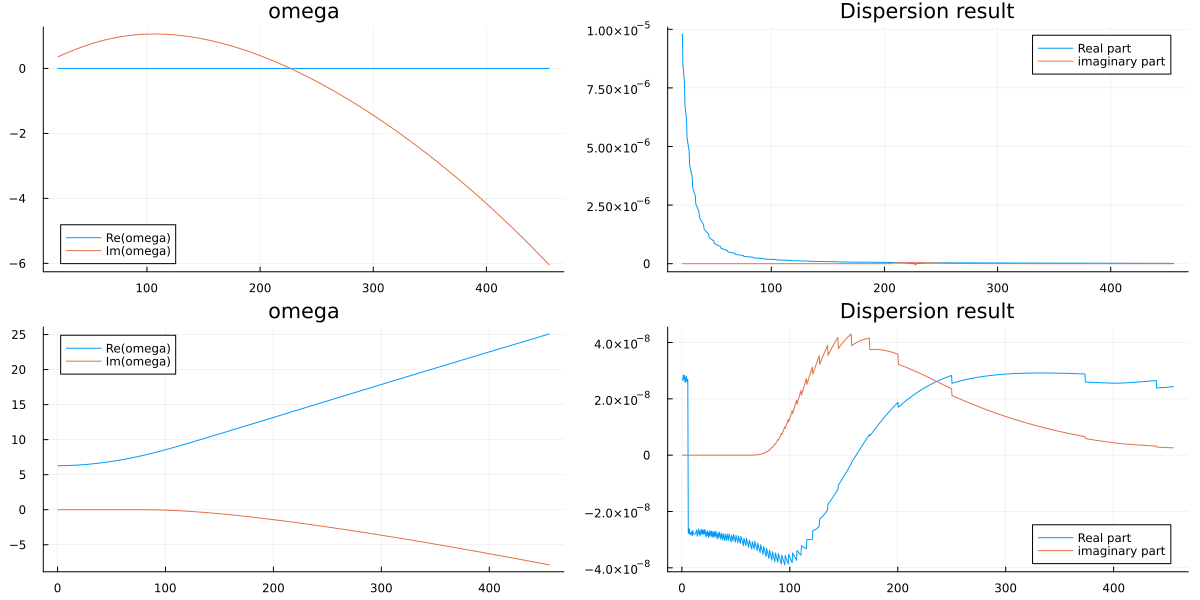

In [25]:
#--------- plot warm solutions 
p1 = plot( k1, real.(omega1), title="omega", label="Re(omega)")
p1 = plot!(k1,imag.(omega1),label="Im(omega)")

p2 = plot( k1, real.(err1), title="Dispersion result", label="Real part")
p2 = plot!(k1,imag.(err1), label = "imaginary part")

p3 = plot( k2, real.(omega2), title="omega", label="Re(omega)")
p3 = plot!(k2,imag.(omega2),label="Im(omega)")

p4 = plot( k2, real.(err2), title="Dispersion result", label="Real part")
p4 = plot!(k2,imag.(err2), label = "imaginary part")

plot(p1, p2, p3, p4, size=(1200,600))

In [26]:
#------------------ Now, find solutions for the warm case with both electrons and ions, using the warm electron-only case as the initial guess for low k
sol_full1 = []
sol_full2 = []

for i in 1:size(k1)[1]
    args_full = (k1[i], V_0, v_t_e, v_t_p, debye_e, debye_i)


    if i < size(k1)[1] / 4
        initial_guess1 = omega1[i] #sol_warm1[i-1]
    else
        initial_guess1 = sol_full1[end][1]
    end
    res1, err1, msg = newton_raphson_complex(x -> function_wrapper(x, args_full...), initial_guess1,max_iterations=500,h=1e-5, step_size=1e-1)
    
    #println(initial_guess1, " ", res1)
    if (abs(err1) < 1e-5) 
        push!(sol_full1, (res1, k_vals[i], err1))
    end
end
for i in 1:size(k2)[1]
    args_full = (k2[i], V_0, v_t_e, v_t_p, debye_e, debye_i)

    initial_guess2 = omega2[i] #sol_warm2[i-1]
    res2, err2,  msg = newton_raphson_complex(x -> function_wrapper(x, args_full...), initial_guess2,max_iterations=500,h=1e-3, step_size=1e-1)
    if (abs(err2) < 1e-5) 
        push!(sol_full2, (res2, k_vals[i], err2))
    end
end 



In [27]:
omega1_full = [vals[1] for vals in sol_full1 ]
k1_full     = [vals[2] for vals in sol_full1 ]
err1_full   = [vals[3] for vals in sol_full1 ]

omega2_full = [vals[1] for vals in sol_full2 ]
k2_full     = [vals[2] for vals in sol_full2 ]
err2_full   = [vals[3] for vals in sol_full2 ];

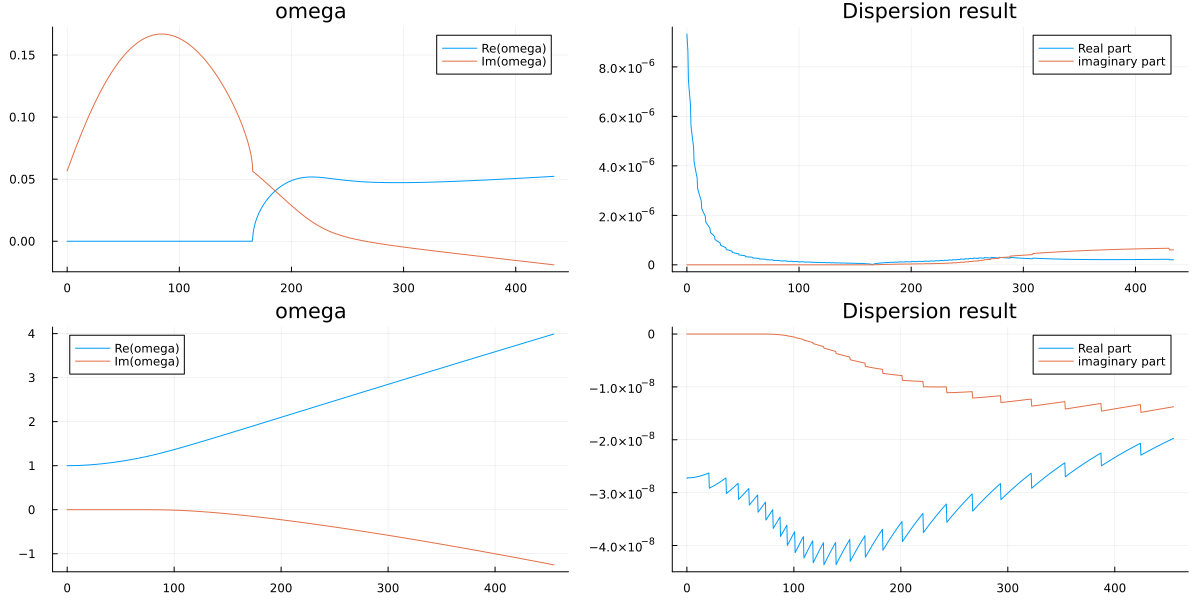

In [28]:
p1 = plot( k1_full, real.(omega1_full) / omega_e, title="omega", label="Re(omega)")
p1 = plot!(k1_full, imag.(omega1_full) / omega_e,label="Im(omega)")

p2 = plot( k1_full, real.(err1_full), title="Dispersion result", label="Real part")
p2 = plot!(k1_full, imag.(err1_full), label = "imaginary part")

p3 = plot( k2_full, real.(omega2_full) / omega_e, title="omega", label="Re(omega)")
p3 = plot!(k2_full, imag.(omega2_full) / omega_e,label="Im(omega)")

p4 = plot( k2_full, real.(err2_full), title="Dispersion result", label="Real part")
p4 = plot!(k2_full, imag.(err2_full), label = "imaginary part")

plot(p1, p2, p3, p4, size=(1200,600))

In [32]:
k_max_full = k1_full[argmax(imag.(omega1_full))]
omega_imag_max_full = omega1_full[argmax(imag.(omega1_full))]
println("Highighest growth rate for for k = ", k_max_full)
println("Here omeage is = ", omega_imag_max_full)

Highighest growth rate for for k = 84.33732834931428
Here omeage is = -1.0596774098066494e-16 + 1.0488996974796718im
